# Pair Trading with Kalman Filter - Dynamic Hedge Ratio Analysis

## Objective
This exercise aims to use a Kalman filter to estimate the **dynamic hedge ratio** between pairs of related stocks for potential **pair trading**. Your goal is to identify which pair of stocks has the highest probability of yielding profitable trading signals.


In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import itertools
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf
from datetime import date
import warnings


warnings.filterwarnings('ignore')


### Task 1 - Data Preprocessing
1. Load and verify the quality of the data.
2. Aggregate the data to x-minute interval

In [11]:
def get_data(): 
    A = pd.read_csv(r"data\A.csv")
    B = pd.read_csv(r"data\B.csv")
    C = pd.read_csv(r"data\C.csv")
    return A, B,C 

def data_analysis(df, name = "X"):
    # understanding data 
    print("Data Description:", "\n")
    print(df.describe())

    require = ["exg_time","trade_price","trade_qty"]
    missing = [c for c in require if c not in df.columns]
    if missing:
        return {"name": name, "error": f"missing columns: {missing}"}

    d = df.copy()
    # time stamp analysis 
    d["exg_time"] = pd.to_datetime(d["exg_time"], utc=True, errors="coerce")
    d = d.sort_values("exg_time")

    out = {}
    out["name"] = name
    out["rows"] = len(d)

    # nan values, missing values 
    out["null_exg_time"] = int(d["exg_time"].isna().sum())
    out["null_price"]    = int(d["trade_price"].isna().sum())
    out["null_qty"]      = int(d["trade_qty"].isna().sum())
    out["nonpos_price"]  = int((d["trade_price"] <= 0).sum())
    out["nonpos_qty"]    = int((d["trade_qty"] <= 0).sum())

    # time range
    out["start"] = str(d["exg_time"].min())
    out["end"]   = str(d["exg_time"].max())

    # check exact duplicated rows 
    keys = ["exg_time", "trade_price", "trade_qty"]

    dup_mask = df.duplicated(subset=keys, keep="first")   # marks ONLY the later repeats
    dup_count = int(dup_mask.sum())
    out["duplicated rows"] = dup_count 

    return out

def data_cleaning(df):
    TICK_KEYS = ["exg_time", "trade_price", "trade_qty"]
    d = df.copy()
    d["exg_time"] = pd.to_datetime(d["exg_time"], utc=True, errors="coerce")

    # drop null time
    d = d.dropna(subset=["exg_time"])

    # drop negative price or negative qty
    d = d[(d["trade_price"] > 0) & (d["trade_qty"] > 0)]

    # drop exact duplicates (keep first only)
    d = d.drop_duplicates(subset=TICK_KEYS, keep="first")

    # sort
    d = d.sort_values("exg_time").reset_index(drop=True)

    return d 

def make_vwap_bars(df, freq="15min",
                   time_col="exg_time",
                   price_col="trade_price",
                   qty_col="trade_qty"):
    d = df.copy()
    d[time_col] = pd.to_datetime(d[time_col], utc=True, errors="coerce")
    d = d.dropna(subset=[time_col]).sort_values(time_col)
    d = d[(d[price_col] > 0) & (d[qty_col] > 0)]

    d["pxq"] = d[price_col] * d[qty_col]
    g = d.set_index(time_col).groupby(pd.Grouper(freq=freq))

    vol = g[qty_col].sum()
    vwap = g["pxq"].sum() / vol

    out = pd.DataFrame({"vwap": vwap, "vol": vol})
    out = out[(out["vol"] > 0) & out["vwap"].notna()]
    return out

def choose_x(df1_clean, df2_clean, candidates=(5, 15, 30), min_aligned=1500):
    """
    Choose x-minutes for a pair using only data coverage.
    Returns: best_x, diagnostics dict.
    """
    # overlap window on ticks
    t1 = pd.to_datetime(df1_clean["exg_time"], utc=True, errors="coerce").dropna()
    t2 = pd.to_datetime(df2_clean["exg_time"], utc=True, errors="coerce").dropna()
    start = max(t1.min(), t2.min())
    end   = min(t1.max(), t2.max())

    best = None
    diag = {}

    for m in candidates:
        freq = f"{m}min"
        b1 = make_vwap_bars(df1_clean, freq=freq).loc[start:end, "vwap"]
        b2 = make_vwap_bars(df2_clean, freq=freq).loc[start:end, "vwap"]
        aligned = pd.concat([b1, b2], axis=1).dropna()

        diag[m] = {"aligned_bars": int(len(aligned))}

        if len(aligned) >= min_aligned and best is None:
            best = m

    if best is None:
        best = candidates[-1] 

    return best, diag

def build_pair_series(df1_clean, df2_clean, x_minutes, name1="X1", name2="X2"):
    freq = f"{x_minutes}min"
    b1 = make_vwap_bars(df1_clean, freq=freq)["vwap"].rename(name1)
    b2 = make_vwap_bars(df2_clean, freq=freq)["vwap"].rename(name2)
    pair = pd.concat([b1, b2], axis=1).dropna()
    x_t = pair[name1]
    y_t = pair[name2]
    return x_t, y_t, pair

def cleaned_data():
    A, B, C = get_data()

    print(data_analysis(A, "A"))
    print(data_analysis(B, "B"))
    print(data_analysis(C, "C"))

    A_clean = data_cleaning(A)
    B_clean = data_cleaning(B)
    C_clean = data_cleaning(C)

    x_AB, diag_AB = choose_x(A_clean, B_clean)
    x_AC, diag_AC = choose_x(A_clean, C_clean)
    x_BC, diag_BC = choose_x(B_clean, C_clean)

    xA_AB, yB_AB, AB = build_pair_series(A_clean, B_clean, x_AB, "A", "B")
    xA_AC, yC_AC, AC = build_pair_series(A_clean, C_clean, x_AC, "A", "C")
    xB_BC, yC_BC, BC = build_pair_series(B_clean, C_clean, x_BC, "B", "C")

    return {
        "A_clean": A_clean, "B_clean": B_clean, "C_clean": C_clean,
        "x_AB": x_AB, "x_AC": x_AC, "x_BC": x_BC,
        "diag_AB": diag_AB, "diag_AC": diag_AC, "diag_BC": diag_BC,
        "AB": AB, "AC": AC, "BC": BC
    }


In [12]:
A, B, C = get_data()

print(data_analysis(A, name = "A"))
print(data_analysis(B, name = "B"))
print(data_analysis(C, name = "C"))

Data Description: 

         trade_price      trade_qty
count  460248.000000  460248.000000
mean    33513.581460     402.947759
std      1378.703901     780.900078
min     31600.000000     100.000000
25%     32320.000000     100.000000
50%     33430.000000     200.000000
75%     34120.000000     400.000000
max     36600.000000   72500.000000
{'name': 'A', 'rows': 460248, 'null_exg_time': 6, 'null_price': 0, 'null_qty': 0, 'nonpos_price': 0, 'nonpos_qty': 0, 'start': '2024-01-02 01:00:00.150894+00:00', 'end': '2024-04-03 09:04:55.015295+00:00', 'duplicated rows': 134292}
Data Description: 

         trade_price      trade_qty
count  339588.000000  339588.000000
mean    28559.525366     358.073901
std       494.355500     706.291635
min     27620.000000     100.000000
25%     28200.000000     100.000000
50%     28370.000000     200.000000
75%     28910.000000     300.000000
max     29880.000000  119900.000000
{'name': 'B', 'rows': 339588, 'null_exg_time': 0, 'null_price': 0, 'null_qty': 

### Comments on Data 
* Data is somewhat clean, some null "exg_time" in A.
* No null values in price and qty for all A,B,C
* A LOT of duplicated rows (exact values for all 3 columns:["exg_time", "trade_price", "trade_qty"]) 
* handled by dropping rows with null "exg_time" value + dropping all duplicated rows, only keeping the first instance. 

### Task 2 - Implement Kalman Filter for Hedge Ratio Estimation
1. Write a function to apply the **Kalman filter** and estimate the hedge ratio between two stocks dynamically over time.
2. Calculate the hedge ratio for each of the pairs


In [13]:


def init_beta0_ols_no_intercept(x, y, n0=200):
    """
    Initialize beta0 via OLS slope with no intercept on the first n0 points.
    x, y: aligned pd.Series
    """
    x0 = x.iloc[:n0].astype(float).values
    y0 = y.iloc[:n0].astype(float).values

    denom = np.dot(x0, x0)
    if denom == 0:
        raise ValueError("init_beta0: x has zero energy in the init window.")
    beta0 = np.dot(x0, y0) / denom
    return float(beta0)


def init_beta0_ols_with_intercept(x, y, n0=200):
    X = sm.add_constant(x.iloc[:n0].astype(float).values)
    Y = y.iloc[:n0].astype(float).values
    res = sm.OLS(Y, X).fit()
    alpha0, beta0 = res.params
    return float(alpha0), float(beta0)

def kalman_beta_filter(x, y, Q, R, beta0=None, P0=1.0, n0=200):
    """
    Scalar Kalman filter for time-varying hedge ratio beta_t in:
        y_t = beta_t * x_t + eps_t,  eps_t ~ N(0, Q)
        beta_t = beta_{t-1} + eta_t, eta_t ~ N(0, R)

    Inputs:
      x, y: aligned pd.Series (same index), float-like
      Q: measurement noise variance (spread noise)
      R: process noise variance (beta drift)
      beta0: optional override initial beta
      P0: initial variance of beta estimate
      n0: init window for beta0 if beta0 is None
      clip_beta: e.g. (0, 3) to keep hedge ratio sane (optional)

    Returns:
      beta_post: pd.Series of posterior beta estimates
      P_post: pd.Series of posterior variances
      spread_post: pd.Series of posterior spread (y - beta*x)
      diagnostics: dict of Series (beta_prior, P_prior, K, resid, S)
    """
    x = x.astype(float)
    y = y.astype(float)
    if not x.index.equals(y.index):
        raise ValueError("x and y must be aligned on the same index.")

    if Q <= 0 or R < 0 or P0 <= 0:
        raise ValueError("Require Q>0, R>=0, P0>0.")

    # init beta
    beta = init_beta0_ols_no_intercept(x, y, n0=n0) if beta0 is None else float(beta0)
    P = float(P0)

    # init storing 
    n = len(x)
    beta_prior = np.empty(n)
    P_prior = np.empty(n)
    beta_post = np.empty(n)
    P_post = np.empty(n)
    K_list = np.empty(n)
    resid = np.empty(n)
    S_list = np.empty(n)
    spread_post = np.empty(n)

    for i in range(n):
        xt = x.iat[i]
        yt = y.iat[i]

        # prior
        b_prior = beta
        Pp = P + R

        # estimation errors 
        e = yt - xt * b_prior
        S = (xt * xt) * Pp + Q

        # Gain 
        K = (Pp * xt) / S

        # Posterior (update) 
        b_post = b_prior + K * e
        Pn = (1.0 - K * xt) * Pp

        # store
        beta_prior[i] = b_prior
        P_prior[i] = Pp
        resid[i] = e
        S_list[i] = S
        K_list[i] = K
        beta_post[i] = b_post
        P_post[i] = Pn
        spread_post[i] = yt - xt * b_post  # posterior spread

        # reassignment
        beta = b_post
        P = Pn

    idx = x.index
    out = (
        pd.Series(beta_post, index=idx, name="beta_hat"),
        pd.Series(P_post, index=idx, name="P"),
        pd.Series(spread_post, index=idx, name="spread"),
        {
            "beta_prior": pd.Series(beta_prior, index=idx, name="beta_prior"),
            "P_prior": pd.Series(P_prior, index=idx, name="P_prior"),
            "K": pd.Series(K_list, index=idx, name="K"),
            "resid": pd.Series(resid, index=idx, name="resid"),
            "S": pd.Series(S_list, index=idx, name="S"),
        }
    )
    return out

# functions used to compute R 
def rolling_beta_no_intercept(x, y, window=200):
    num = (x*y).rolling(window).sum()
    den = (x*x).rolling(window).sum()
    return (num/den).dropna()

def estimate_R_from_rolling_beta(x, y, window=200):
    beta_roll = rolling_beta_no_intercept(x, y, window=window)
    d_beta = beta_roll.diff().dropna()
    R_hat = float(d_beta.var(ddof=1))
    return R_hat, beta_roll


def QR(x, y, beta0, n0, window):
    """
    Q: variance of initial residuals using beta0
    R: small process variance (beta drift), proportional to Q
    Inputs: 
        - n0 : init window for beta0 if beta0 is None - longer the better
        - window : init window for R - longer the better
    """
    x0 = x.iloc[:n0].astype(float)
    y0 = y.iloc[:n0].astype(float)
    e0 = (y0 - beta0 * x0)
    Q = float(e0.var(ddof=1))
    R, beta_roll = estimate_R_from_rolling_beta(x, y, window)
    return Q, R


def sanity_check(x, y, beta_hat, P_hat, spread, diag, Q, plot = True):
    # S identity check
    S_recon = diag["P_prior"] * (x**2) + Q
    err = (diag["S"] - S_recon).abs()
    print("max |S - (x^2 P_prior + Q)| =", float(err.max()))

    # Normalized residuals
    z = diag["resid"] / np.sqrt(diag["S"])
    print("normalized residuals z: mean =", float(z.mean()), "std =", float(z.std()))

    if plot == True:
        beta_hat.plot(title="beta_hat (posterior)")
        plt.show()
        P_hat.plot(title="P (posterior variance)")
        plt.show()
        diag["K"].plot(title="Kalman gain K_t")
        plt.show()
        
    return z


### Summary:
* We construct aligned 5-min VWAP bars.
* Initialize $\beta_0$ via OLS (no intercept) on first 200 bars
* Set $Q$ as variance of initial residuals.
* Set $R$ as variance of $\Delta \beta$ from rolling OLS using window of 60. 

### Comments: 
* We have checked that the computation of the residual variance is mathematically consistent with (equation 11) in J.Yu
* With the computed mean and variance, Q and R are reasonably calibrated. 

### Task 3 - Calculate the Spread for Each Pair
1. Using the hedge ratio estimated in Task 2, compute a **spread** for each pair
2. **Check Mean Reversion**: Before applying the strategy, check if the spread between the pairs shows signs of mean reversion.

In [14]:
def calculate_spread(df, x_col, y_col, beta_hat):
    """
    spread_t = y_t - beta_t * x_t
    """
    df["beta_hat"] = beta_hat
    df = df.dropna()
    spread = df[y_col] - df['beta_hat'] * df[x_col]
    return spread

def cadf_test(df, x, y, add_const=True, autolag="AIC"):
    """
    Engle-Granger residual-based ADF (CADF).
    Regress y on x, then ADF test on residuals.
    """

    X = df[x].values
    Y = df[y].values

    if add_const:
        Xreg = sm.add_constant(X)
        res = sm.OLS(Y, Xreg).fit()
        alpha, beta = res.params
        resid = Y - (alpha + beta * X)
    else:
        res = sm.OLS(Y, X).fit()
        beta = res.params[0]
        alpha = 0.0
        resid = Y - beta * X

    adf_res = adfuller(resid, autolag=autolag, regression="c")
    return {
        "adf_stat": float(adf_res[0]),
        "p_value": float(adf_res[1])
    }

def plot_spread_acf(spread: pd.Series, lags: int = 60, title: str = "ACF of spread"):
    s = pd.Series(spread).dropna().astype(float)

    plt.figure(figsize=(9, 4))
    plot_acf(s.values, lags=lags, zero=False)
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.tight_layout()
    plt.show()

def mean_reverting_test(spread, df, x_col, y_col, autolag ="AIC", plot = True): 
    # ADF 
    spread.dropna(inplace=True)
    adf_res = adfuller(spread, autolag = autolag)
    print("ADF stat:", adf_res[0], "p value:", adf_res[1])
    
    # Johansen
    df = df[[x_col, y_col]]
    j = coint_johansen(df, det_order=0, k_ar_diff=1)
    trace_r0 = j.lr1[0]
    crit95_r0 = j.cvt[0, 1]  

    print(f"Johansen Trace (r=0): {trace_r0:.4f} | 95% CV: {crit95_r0:.4f}")
    if trace_r0 > crit95_r0:
        print("=> Johansen: reject r=0 → rank ≥ 1 → cointegrated (by trace at 95%)")
    else:
        print("=> Johansen: fail to reject r=0 → not cointegrated at 95% (by trace)")

    # ACF plot
    if plot:
        plot_spread_acf(spread, lags=60, title="ACF: Kalman spread")
    
    
    


### Summary: 
* Used Autocorrelation plot to check mean reverting. 
* Used ADF to check stationarity of Kalman spread 
* Check cointegration betweem Assets using CADF, ADF and Johansen Tests (key assumption in paper)

### Task 4 - Simulate Trading Strategy and Profitability
1. Define a simple **mean-reversion trading strategy**, assuming no trading cost.
2. Calculate the **cumulative profit and loss (P&L)** for each pair based on this strategy.
3. Record the cumulative P&L for each pair at the end of the period.

In [15]:
## trading class 
class TradingEngine:
    def __init__(self, initial_capital=100000.0, commission_bps=0):
        self.cash = initial_capital
        self.initial_capital = initial_capital
        self.commission_bps = commission_bps
        self.positions = {} # {ticker: {'qty': 0, 'avg_price': 0.0}}
        self.history = []
        self.equity_curve = [] # Track daily portfolio value

    def get_portfolio_value(self, current_prices):
        """Returns Cash + Market Value of Positions"""
        market_value = 0.0
        for ticker, pos in self.positions.items():
            if ticker in current_prices:
                market_value += pos['qty'] * current_prices[ticker]
        return self.cash + market_value

    def execute_order(self, ticker, qty, price, date, action_label):
        """
        Handles Buy/Sell logic including Cash deduction.
        """
        if qty == 0: 
            return

        # Calculate Cost & Commission
        notional = abs(qty * price)
        comm = notional * self.commission_bps 
        
        self.cash -= (qty * price) 
        self.cash -= comm
        
        # Update Position 
        current_pos = self.positions.get(ticker, {'qty': 0, 'avg_price': 0.0})
        curr_qty = current_pos['qty']
        
        # Check direction
        is_same_direction = (curr_qty * qty) > 0 or curr_qty == 0
        
        if is_same_direction:
            # scale in 
            new_total_qty = curr_qty + qty
            old_notional = curr_qty * current_pos['avg_price']
            new_trade_notional = qty * price
        
            new_avg_price = price
            if new_total_qty != 0:
                new_avg_price = (old_notional + new_trade_notional) / new_total_qty
            
            self.positions[ticker] = {'qty': new_total_qty, 'avg_price': new_avg_price}
            
        else:
            # update quantity 
            new_total_qty = curr_qty + qty
            if new_total_qty == 0:
                if ticker in self.positions: del self.positions[ticker]
            else:
                is_flip = (curr_qty * new_total_qty) < 0
                new_avg_price = price if is_flip else current_pos['avg_price']
                self.positions[ticker] = {'qty': new_total_qty, 'avg_price': new_avg_price}

        # log trade
        self.history.append({
            'date': date, 'ticker': ticker, 'action': action_label,
            'qty': qty, 'price': price, 'comm': comm
        })
        
def portfolio_analytics(equity: pd.Series):
    equity_daily = equity.resample('B').last().dropna()
    rets_daily = equity_daily.pct_change().dropna()
    
    # Sharpe 
    if rets_daily.std() != 0:
        sharpe = (rets_daily.mean() / rets_daily.std()) * np.sqrt(252)
    else:
        sharpe = 0.0

    # Vol 
    ann_vol = rets_daily.std() * np.sqrt(252)

    # CAGR 
    start_date = equity_daily.index[0]
    end_date = equity_daily.index[-1]
    years = (end_date - start_date).days / 365.25
    
    if years > 0:
        cagr = (equity_daily.iloc[-1] / equity_daily.iloc[0]) ** (1/years) - 1 
    else:
        cagr = 0.0
    
    # DD
    peak = equity.cummax()
    dd = equity / peak - 1.0
    max_dd = dd.min()

    # Max DD duration (in days)
    peak_daily = equity_daily.cummax()
    underwater_daily = equity_daily < peak_daily
    
    dd_duration = (underwater_daily.groupby((underwater_daily != underwater_daily.shift()).cumsum())
                   .cumcount() + 1)
    max_dd_duration = dd_duration[underwater_daily].max() if underwater_daily.any() else 0

    return {
        "Final Equity": float(equity.iloc[-1]),
        "Total Return": float(equity.iloc[-1] / equity.iloc[0] - 1),
        "CAGR": float(cagr),
        "Ann Vol": float(ann_vol),
        "Sharpe (rf=0)": float(sharpe),
        "Max Drawdown": float(max_dd),
        "Max DD Duration (days)": int(max_dd_duration),
    }, dd, rets_daily

def run_z_score_backtest(res, engine, X="A", Y="B", pair_name="AB", entry_z=2.0, exit_z=0.0, window = 20):
    """
    Self-contained pipeline:
    1. Runs CADF test (prints results)
    2. Runs Kalman Filter (calculates dynamic beta)
    3. Runs Trading Simulation
    4. Returns Equity Curve
    """
    
    # 1. Data Setup 
    if pair_name not in res:
        raise ValueError(f"Pair {pair_name} not found in results dictionary.")
        
    df = res[pair_name].dropna().copy()
    x_series = df[X]
    y_series = df[Y]
    
    # Cointegration Test (CADF)
    print(f"\n--- Running Analysis for Pair: {pair_name} ---")
    cadf_res = cadf_test(df, X, Y) 
    print(f"CADF p-value: {cadf_res['p_value']:.5f} (Stat: {cadf_res['adf_stat']:.4f})")

    # Kalman Filter Implementation 
    # init beta
    beta0 = init_beta0_ols_no_intercept(x_series, y_series, n0=200)
    
    # calculate Q and R parameters
    Q, R = QR(x_series, y_series, beta0, n0=200, window=200)
    print(f"Kalman Parameters -> Beta0: {beta0}, Q: {Q}, R: {R}")

    # kalman filter
    beta_hat, P_hat, spread, diag = kalman_beta_filter(
        x_series, y_series,
        Q=Q, R=R,
        beta0=beta0,
        P0=1.0,
        n0=200
    )
  
    # sanity check 
    z_check = sanity_check(x_series, y_series, beta_hat, P_hat, spread, diag, Q, False)

    df['spread'] = calculate_spread(df, X, Y, beta_hat) # Recalculate to be safe

    mean_reverting_test(spread = df['spread'], df = res[pair_name], x_col = X, y_col = Y, autolag="AIC", plot=False)

    # z score calculation
    spread_mean = df['spread'].rolling(window).mean().shift(1)
    spread_std  = df['spread'].rolling(window).std().shift(1)
    df['z_score'] = (df['spread'] - spread_mean) / spread_std

    # trade on next bar 
    df['beta_trade'] = df['beta_hat'].shift(1)
    df['z_trade']    = df['z_score'].shift(1)
    
    # trading simu
    print("Starting Trading Simulation...")
    current_state = 0 # 0=Flat, 1=Long Spread, -1=Short Spread
    
    for i, (index, row) in enumerate(df.iterrows()):

        if i < window or pd.isna(row['z_score']) or pd.isna(row['beta_hat']): 
            continue

        # Current Market Data
        z = row['z_trade']
        beta = row['beta_trade']
        price_x = row[X]
        price_y = row[Y]
        date = index
        
        # Dynamic Hedge
        base_qty = 100
        hedge_qty = base_qty * beta
        
        # Trading Logic
        if current_state == 0 and z < -entry_z:
            # Entry Long Spread: Buy Y, Sell Beta*X
            engine.execute_order(Y, base_qty, price_y, date, "BUY Y (Long)")
            engine.execute_order(X, -hedge_qty, price_x, date, "SELL X (Hedge)")
            current_state = 1
            
        elif current_state == 0 and z > entry_z:
            # Entry Short Spread: Sell Y, Buy Beta*X
            engine.execute_order(Y, -base_qty, price_y, date, "SELL Y (Short)")
            engine.execute_order(X, hedge_qty, price_x, date, "BUY X (Hedge)")
            current_state = -1
            
        elif current_state == 1 and z >= -exit_z:
            # Exit Long
            engine.execute_order(Y, -base_qty, price_y, date, "CLOSE Y")
            engine.execute_order(X, hedge_qty, price_x, date, "CLOSE X")
            current_state = 0
            
        elif current_state == -1 and z <= exit_z:
            # Exit Short
            engine.execute_order(Y, base_qty, price_y, date, "CLOSE Y")
            engine.execute_order(X, -hedge_qty, price_x, date, "CLOSE X")
            current_state = 0
            
        # Mark to Market (Record Equity)
        prices = {X: price_x, Y: price_y}
        engine.equity_curve.append({'date': date, 'equity': engine.get_portfolio_value(prices)})

    #  Results
    print("Simulation Complete.")
    return pd.DataFrame(engine.equity_curve).set_index('date')

### Task 5 - Conclusion
1. Identify which pair produced the **highest cumulative P&L**.
2. Summarize your results and provide an interpretation of which pair is the most likely to yield a profitable trading opportunity.

In [16]:
def run_all_permutations(res):
    """
    Runs the Kalman Strategy on all 6 permutations of the assets:
    (B|A), (A|B), (C|A), (A|C), (C|B), (B|C).
    Returns a dictionary of equity curves.
    """
    results = {}
    stats_dict = {}
    
    # (Data Key in 'res', Independent Var X, Dependent Var Y)
    # Y = beta * X + spread
    permutations = [
        ("AB", "A", "B"), # Model B against A
        ("AB", "B", "A"), # Model A against B
        ("AC", "A", "C"),
        ("AC", "C", "A"),
        ("BC", "B", "C"),
        ("BC", "C", "B")
    ]
    
    for key, x_col, y_col in permutations:
        #  "Y_vs_X" means we are trading Y, hedging with X
        strat_name = f"{y_col}_vs_{x_col}" 
        print(f"\n{'='*10} RUNNING STRATEGY: {strat_name} {'='*10}")
        
        engine = TradingEngine(initial_capital=100000.0)
        
        try:

            equity = run_z_score_backtest(
                res=res, 
                engine=engine, 
                X=x_col, 
                Y=y_col, 
                pair_name=key, 
                entry_z=2.0, 
                exit_z=0.0, 
                window= 20 
            )
            
            results[strat_name] = equity
            
            final_val = equity['equity'].iloc[-1]
            ret = (final_val / 100000.0) - 1.0
            print(f"-> Final Equity: ${final_val:,.2f} ({ret*100:.2f}%)")
            stats, dd, rets = portfolio_analytics(equity['equity'])
            stats_dict[strat_name] = stats
            print(f"Portfolio Stats for pair {y_col}_vs_{x_col}: \n", pd.Series(stats))
        except Exception as e:
            print(f"!! Error running {strat_name}: {e}")
            
    return results, stats_dict

def plot_strategy_performance(results):
    """
    Plots the equity curves of all simulations on a single chart.
    """
    plt.figure(figsize=(12, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results))) # type: ignore 
    
    for (name, df), color in zip(results.items(), colors):
        # Calculate percentage return for the Y-axis label
        final_equity = df['equity'].iloc[-1]
        start_equity = df['equity'].iloc[0]
        total_ret = ((final_equity / start_equity) - 1) * 100
        
        plt.plot(df.index, df['equity'], label=f"{name} (+{total_ret:.1f}%)", linewidth=2, alpha=0.8, color=color)

    plt.title("Kalman Pairs Trading: Strategy Comparison (6 Permutations)", fontsize=14, pad=15)
    plt.ylabel("Portfolio Equity ($)", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

Data Description: 

         trade_price      trade_qty
count  460248.000000  460248.000000
mean    33513.581460     402.947759
std      1378.703901     780.900078
min     31600.000000     100.000000
25%     32320.000000     100.000000
50%     33430.000000     200.000000
75%     34120.000000     400.000000
max     36600.000000   72500.000000
{'name': 'A', 'rows': 460248, 'null_exg_time': 6, 'null_price': 0, 'null_qty': 0, 'nonpos_price': 0, 'nonpos_qty': 0, 'start': '2024-01-02 01:00:00.150894+00:00', 'end': '2024-04-03 09:04:55.015295+00:00', 'duplicated rows': 134292}
Data Description: 

         trade_price      trade_qty
count  339588.000000  339588.000000
mean    28559.525366     358.073901
std       494.355500     706.291635
min     27620.000000     100.000000
25%     28200.000000     100.000000
50%     28370.000000     200.000000
75%     28910.000000     300.000000
max     29880.000000  119900.000000
{'name': 'B', 'rows': 339588, 'null_exg_time': 0, 'null_price': 0, 'null_qty': 

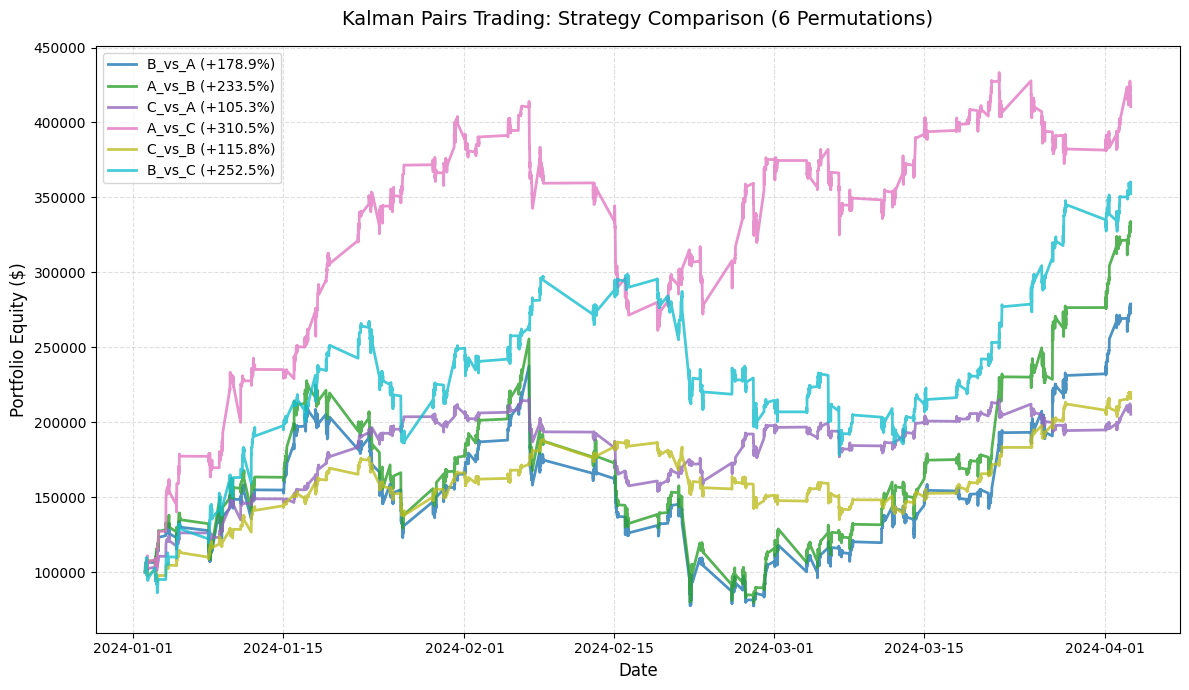

 Best Performing Pair: A_vs_C with sharpe ratio: 5.223707837502907


In [17]:
res = cleaned_data() 
print("best x min for AB:", res['x_AB'])
print("best x min for AC:", res['x_AC'])
print("best x min for BC:", res['x_BC'])

all_strategies, stat_dict = run_all_permutations(res)

plot_strategy_performance(all_strategies)

best_strat = max(all_strategies, key=lambda k: all_strategies[k]['equity'].iloc[-1])
best_strat_stats = stat_dict[best_strat]
print(f" Best Performing Pair: {best_strat} with sharpe ratio: {best_strat_stats['Sharpe (rf=0)']}")

### Robustness Checks, Optimization Experiments 


Starting 3D Scan for AC (A | C)... scoring on test


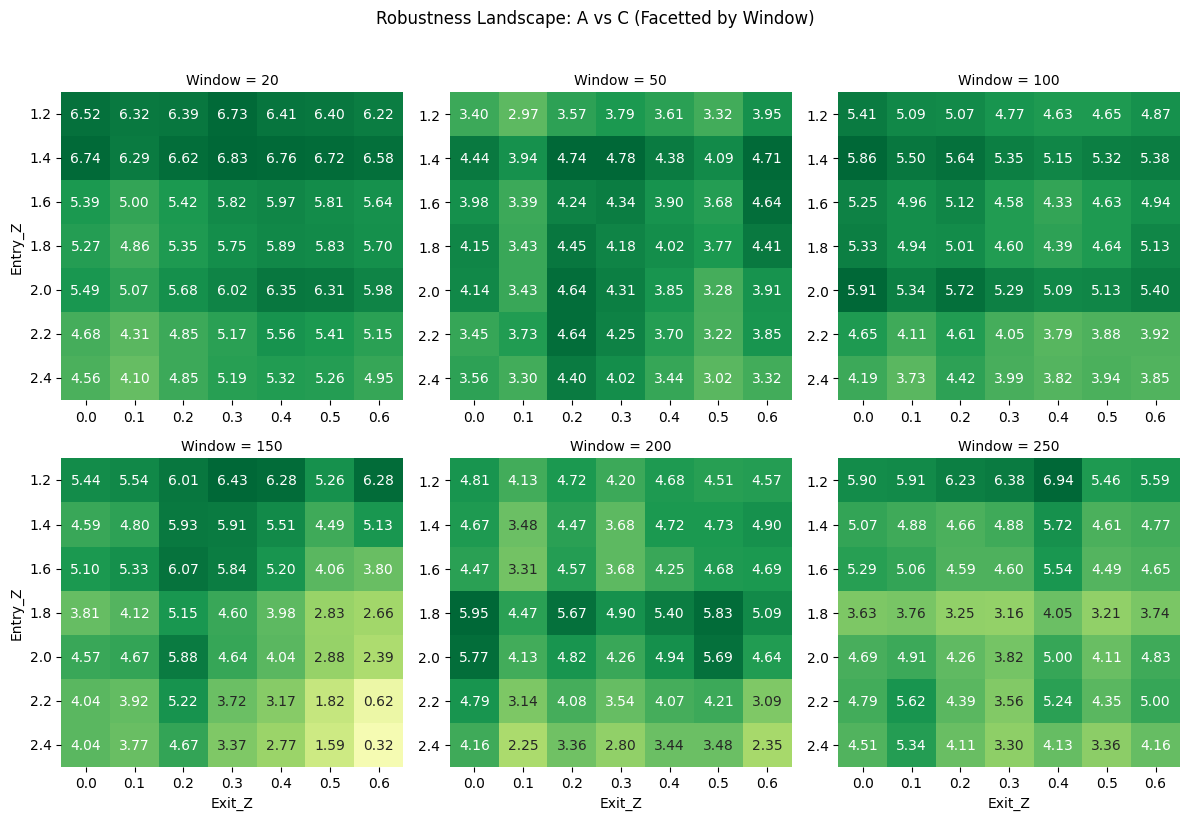

In [18]:

def run_efficient_sensitivity_analysis(res, x_col, y_col, pair_name, windows, entries, exits, split=(0,0,1), score_on="test"):
    """
    Optimized Grid Search:
    - Calculates Kalman/Z-Score ONCE per window.
    - Runs Trading Loop for multiple Entry/Exits.
    """
    if pair_name not in res:
        raise ValueError(f"Pair {pair_name} not found.")
    
    base_df = res[pair_name].dropna().copy()

    # --- (C) time split ---
    n = len(base_df)
    n_train = int(split[0] * n)
    n_val   = int((split[0] + split[1]) * n)

    train_df = base_df.iloc[:n_train].copy()
    val_df   = base_df.iloc[n_train:n_val].copy()
    test_df  = base_df.iloc[n_val:].copy()

    if score_on == "val":
        score_df = val_df
    elif score_on == "test":
        score_df = test_df
    else:
        raise ValueError("score_on must be 'val' or 'test'")

    # Use full series for filtering (keeps realistic continuity)
    x_series = base_df[x_col]
    y_series = base_df[y_col]

    results = []
    print(f"Starting 3D Scan for {pair_name} ({y_col} | {x_col})... scoring on {score_on}")

    for w in windows:
        # Heavy lift: parameter estimation (you can restrict to train_df if desired)

        beta0 = init_beta0_ols_no_intercept(x_series, y_series, n0=200)
        Q, R = QR(x_series, y_series, beta0, n0=200, window=w)

        beta_hat, _, spread, _ = kalman_beta_filter(x_series, y_series, Q=Q, R=R, beta0=beta0)

        sim_df = base_df.copy()
        sim_df['beta_hat'] = beta_hat
        sim_df['spread'] = spread.reindex(sim_df.index)

        # Z-score computed from past only (prevents same-bar leakage via rolling stats)
        roll_mean = sim_df['spread'].rolling(window=w).mean().shift(1)
        roll_std  = sim_df['spread'].rolling(window=w).std().shift(1)
        sim_df['z_score'] = (sim_df['spread'] - roll_mean) / roll_std

        # --- (B) trade on lagged signal/beta ---
        sim_df['z_trade']    = sim_df['z_score'].shift(1)
        sim_df['beta_trade'] = sim_df['beta_hat'].shift(1)

        # drop rows where trading inputs not available
        sim_df = sim_df.dropna(subset=['z_trade', 'beta_trade', x_col, y_col]).copy()

        # slice to scoring segment
        sim_df = sim_df.loc[score_df.index.intersection(sim_df.index)].copy()
        if sim_df.empty:
            continue

        dates = sim_df.index
        z_vals = sim_df['z_trade'].values
        b_vals = sim_df['beta_trade'].values
        px_x = sim_df[x_col].values
        px_y = sim_df[y_col].values

        for en, ex in itertools.product(entries, exits):
            # --- (A) enforce exit < entry ---
            if ex >= en:
                continue

            current_state = 0
            cash = 100000.0
            shares_y = 0.0
            shares_x = 0.0

            equity_curve = []

            for i in range(len(z_vals)):
                z = z_vals[i]

                if current_state == 0:
                    if z < -en:
                        beta = b_vals[i]
                        shares_y = 100.0
                        shares_x = -(100.0 * beta)
                        cash -= (shares_y * px_y[i] + shares_x * px_x[i])
                        current_state = 1
                    elif z > en:
                        beta = b_vals[i]
                        shares_y = -100.0
                        shares_x = (100.0 * beta)
                        cash -= (shares_y * px_y[i] + shares_x * px_x[i])
                        current_state = -1

                elif current_state == 1:
                    if z >= -ex:
                        cash += (shares_y * px_y[i] + shares_x * px_x[i])
                        shares_y = 0.0
                        shares_x = 0.0
                        current_state = 0

                elif current_state == -1:
                    if z <= ex:
                        cash += (shares_y * px_y[i] + shares_x * px_x[i])
                        shares_y = 0.0
                        shares_x = 0.0
                        current_state = 0

                nav = cash + (shares_y * px_y[i] + shares_x * px_x[i])
                equity_curve.append(nav)

            eq_series = pd.Series(equity_curve, index=dates)

            # Daily Sharpe on resampled equity
            daily_eq = eq_series.resample('B').last().dropna()
            daily_rets = daily_eq.pct_change().dropna()

            if daily_rets.std() > 0:
                sharpe = (daily_rets.mean() / daily_rets.std()) * np.sqrt(252)
            else:
                sharpe = 0.0

            results.append({
                'Window': w,
                'Entry_Z': en,
                'Exit_Z': ex,
                'Sharpe': sharpe
            })

    return pd.DataFrame(results)
# Plotting Functions

def plot_3d_robustness_fixed_window(df_results, fixed_window=20):
    subset = df_results[df_results['Window'] == fixed_window].copy()
    if subset.empty:
        print(f"No data found for Window = {fixed_window}")
        return

    z_data = subset.pivot(index='Entry_Z', columns='Exit_Z', values='Sharpe')
    x_val = z_data.columns.values  # Exit Z-Scores
    y_val = z_data.index.values    # Entry Z-Scores
    z_val = z_data.values          # Sharpe Ratios

    fig = go.Figure(data=[go.Surface(
        z=z_val, x=x_val, y=y_val,
        colorscale='Viridis', colorbar=dict(title='Sharpe Ratio')
    )])
    fig.update_layout(
        title=f'Strategy Robustness Surface (Fixed Window={fixed_window} days)',
        scene=dict(
            xaxis_title='Exit Threshold (Z-Score)',
            yaxis_title='Entry Threshold (Z-Score)',
            zaxis_title='Sharpe Ratio',
            camera=dict(eye=dict(x=1.6, y=1.6, z=1.3))
        ),
        width=900, height=700, margin=dict(l=65, r=50, b=65, t=90)
    )
    fig.show()

def plot_3d_robustness(df_results, pair_name):
    g = sns.FacetGrid(df_results, col="Window", col_wrap=3, height=4, sharex=True, sharey=True)

    def draw_heatmap(data, **kwargs):
        ax = plt.gca()
        pivot = data.pivot(index='Entry_Z', columns='Exit_Z', values='Sharpe').sort_index()

        sns.heatmap(
            pivot,
            annot=True,
            fmt=".2f",
            cmap="RdYlGn",
            center=0,
            cbar=False,
            ax=ax
        )

        # force axis labels + ticks to show clearly
        ax.set_xlabel("Exit_Z")
        ax.set_ylabel("Entry_Z")
        ax.tick_params(axis='x', rotation=0, labelbottom=True)
        ax.tick_params(axis='y', rotation=0, labelleft=True)

    g.map_dataframe(draw_heatmap)
    g.figure.suptitle(f"Robustness Landscape: {pair_name} (Facetted by Window)", y=1.02)
    plt.tight_layout()
    plt.show()


windows = [20, 50, 100, 150, 200, 250]
entries = [1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4]
exit = [0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]

# Run Scan
robustness_df = run_efficient_sensitivity_analysis(
    res=res, x_col="C", y_col="A", pair_name="AC", 
    windows=windows, entries=entries, exits=exit
)

# Visualize
plot_3d_robustness_fixed_window(robustness_df, fixed_window=20)
plot_3d_robustness(robustness_df, "A vs C")

### Conclusion 
### Key assumptions (per paper / setup)

* **Spread relationship:** $ y_t \approx \beta_t x_t + \epsilon_t$, where $\epsilon_t$ is mean-reverting (stationary) noise.
* **Time‐varying hedge ratio:** $\beta_t$ evolves slowly over time (modeled as a random walk / state process).
* **Observation noise vs state noise:** The Kalman filter separates short-term deviations ($\epsilon_t$) from slower changes in $\beta_t$ controlled by $R$ and $Q$.
* **Tradability premise:** If the constructed spread $s_t = y_t - \beta_t x_t$ is stationary, z-score threshold trading can harvest mean reversion.

---

### Results summary (Pair: A vs C)

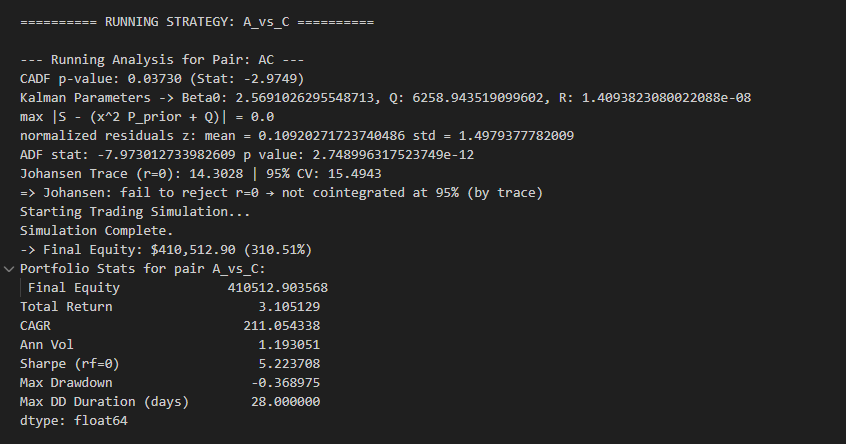

**Cointegration / stationarity checks**

* **CADF on OLS residual (fixed $\beta$)**: p = **0.0373** → supports cointegration at **5%** (borderline pass).
* **ADF on Kalman spread (dynamic $\beta$)**: stat = **−7.973**, p ≈ **2.75e−12** → very strong stationarity of the *traded* spread.
* **Johansen trace (r=0, det_order=0)**: Trace = **14.3028**, 95% CV = **15.4943** → does **not** reject no-cointegration at 95%.
* **Interpretation:** Fixed-β cointegration is supported by CADF but not confirmed by Johansen; the traded Kalman spread is strongly mean-reverting.

**Kalman filter diagnostics**

* $\beta_0 \approx 2.569$
* $Q \approx 6258.94$, $R \approx 1.41 \times 10^{-8}$
* Normalized residuals: mean ≈ **0.109**, std ≈ **1.498** → stable scaling for z-score triggers.

---

### Trading performance (in-sample)

* **Final equity:** $410,512.90 (from $100,000)
* **Total return:** **+310.51%**
* **Sharpe (rf=0):** **5.223708**
* **Annual vol:** **1.193051**
* **Max drawdown:** **−36.897%**

---

### Key comments / limitations (must state)

* **Annualized metrics are unstable on a short sample**: CAGR/Sharpe are directionally informative but should not be treated as definitive.
* **Cointegration is a risk factor**: CADF passes but Johansen does not at 95% under det_order=0.
---

### Conclusion

* A vs C exhibits **strong mean reversion in the Kalman-constructed traded spread**, consistent with the paper’s framework and supportive of z-score spread trading.
* Classical cointegration evidence is **mixed** (CADF pass, Johansen non-confirmation), so cointegration is treated as **model risk**, while the primary validation is the observed stationarity and trading behavior of the **Kalman spread**.
* Results from parameter optimization shows that this pair is relatively robust in terms of parameter tuning in validation, but out of sample tunings requires further robustness checks 



### Corrections
* incorrectly stated "out of sample tunings" - this is wrong, this whole study is a exploratory data bactesting study. all results are in sample, based on data the model has already seen.
* to trade on this model, we will need to change to a predictive study, which will conduct out of sample study. 